# Tehtävä 7: Aikasarjaennusteet

Tässä notebookissa:
1. **Tehtävä 1**: Ennustetaan lentomatkustajadatan vuoden 2023 perusteella vuoden 2024 kuukausittaiset matkustajamäärät (Holt-Winters) ja verrataan todellisiin arvoihin.
2. **Tehtävä 2**: Ennustetaan vuosittainen kokonaishedelmällisyysluku (1776–2024) tuleville vuosille 2025–2034 käyttäen Holt-Winters -mallia ilman kausikomponenttia.  
   - Piirretään ja tallennetaan viivakaavio historiallisen datan ja ennusteen yhdistelmästä.


## 1) Kirjastojen tuonti ja oletusasetukset

Tuodaan tarvittavat kirjastot (`pandas`, `numpy`, `matplotlib.pyplot`, `seaborn`, `statsmodels`, `requests`, `sys`, `json`).  
Asetetaan visuaaliset asetukset Seabornille ja pandasille.


In [15]:
import sys
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Visualisointien oletusasetukset
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# pandas näyttöasetukset, kun tulostetaan DataFrameja
pd.set_option("display.max_rows", 12)
pd.set_option("display.max_columns", None)

## 2) Tehtävä 1: Lentomatkustajadatan aikasarjaennuste (vuosi 2024)

1. Ladataan Excel-taulukko, jossa kuukausittaiset matkustajamäärät.
2. Muunnetaan “Kuukausi”-sarake datetime-indeksiksi (`Pvm`) ja asetetaan `Matkustajat`-sarake aikasarjaksi.
3. Sovitetaan Holt-Winters -malli koko aikasarjalle (trend="add", seasonal="add", period=12).
4. Ennustetaan vuoden 2024 12 kuukautta.
5. Suodatetaan vuoden 2024 todelliset arvot ja lasketaan ennusteen ja todellisten erotus.
6. Piirretään hajontakaavio todellisten vs. ennustettujen arvojen vertailusta ja tallennetaan kuva tiedostoon.

In [16]:
'''
1) Ladataan Excel-tiedosto lentomatkustajadatasta.
'''
excel_path = r"D:\GitHub\PythonDataAnalytics\doc\lentomatkustajat.xlsx"
df_all = pd.read_excel(excel_path, sheet_name=0, engine="openpyxl")

print("Ladatut sarakkeet:", df_all.columns.tolist())

Ladatut sarakkeet: ['Kuukausi', 'Matkustajat']


In [17]:
'''
2) Muunnetaan 'Kuukausi' merkkijonosta datetime-indeksiksi ja asetetaan se DataFramen indeksiksi.
'''
df_all["Pvm"] = pd.to_datetime(df_all["Kuukausi"], format="%YM%m")
df_all = df_all.set_index("Pvm").sort_index()

# Otetaan sarake 'Matkustajat' aikasarjaksi
ts_all = df_all["Matkustajat"].copy()
ts_all.index.freq = "MS"

print("Esimerkki aikasarjasta (2019–2024 loppu):")
print(ts_all.head(), "\n...", ts_all.tail(), sep="\n")

Esimerkki aikasarjasta (2019–2024 loppu):
Pvm
2019-01-01    798402
2019-02-01    761165
2019-03-01    887909
2019-04-01    904297
2019-05-01    974604
Freq: MS, Name: Matkustajat, dtype: int64

...
Pvm
2024-10-01    743552
2024-11-01    634464
2024-12-01    659934
2025-01-01    608118
2025-02-01    590610
Freq: MS, Name: Matkustajat, dtype: int64


In [18]:
'''
3) Sovitetaan Holt-Winters -malli koko dataan (add trend, add season, period=12).
   Ennustetaan vuoden 2024 matkustajamäärät (12 kuukautta).
'''
hw_model_all = ExponentialSmoothing(
    ts_all,
    trend="add",
    seasonal="add",
    seasonal_periods=12
).fit(optimized=True)

forecast_2024 = hw_model_all.forecast(12)
forecast_2024.index = pd.date_range(start="2024-01-01", periods=12, freq="MS")
forecast_2024.name = "Ennuste2024"

print("Ennustetut arvot vuodelle 2024:")
forecast_2024.to_frame().head(5)

Ennustetut arvot vuodelle 2024:


d:\GitHub\PythonDataAnalytics\env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,Ennuste2024
2024-01-01,553917.797021
2024-02-01,454462.674089
2024-03-01,492013.073706
2024-04-01,515599.929944
2024-05-01,598263.768325


In [19]:
'''
4) Suodatetaan vuoden 2024 todelliset arvot ja lasketaan erotus ennusteeseen verrattuna.
'''
ts_2024 = ts_all[ts_all.index.year == 2024].copy()
ts_2024.index.freq = "MS"
ts_2024.name = "Todellinen2024"

df_compare = pd.DataFrame({
    "Todellinen2024": ts_2024,
    "Ennuste2024": forecast_2024
})
df_compare["Erotus"] = df_compare["Ennuste2024"] - df_compare["Todellinen2024"]

print("Vertailu DataFrame (2024):")
df_compare

Vertailu DataFrame (2024):


,Todellinen2024,Ennuste2024,Erotus
2024-01-01,563864,553917.797021,-9946.202979
2024-02-01,560131,454462.674089,-105668.325911
2024-03-01,650377,492013.073706,-158363.926294
2024-04-01,648527,515599.929944,-132927.070056
2024-05-01,707745,598263.768325,-109481.231675
2024-06-01,759746,562485.469003,-197260.530997
2024-07-01,824956,525486.211255,-299469.788745
2024-08-01,742143,545494.261251,-196648.738749
2024-09-01,708998,474606.724525,-234391.275475
2024-10-01,743552,511323.591427,-232228.408573


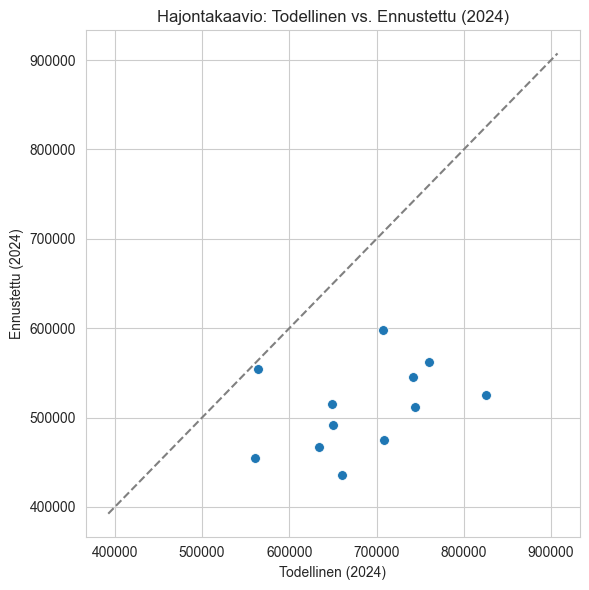

In [20]:
'''
5) Piirretään hajontakaavio: Todellinen vs. Ennustettu 2024 ja tallennetaan kuva.
'''
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x="Todellinen2024",
    y="Ennuste2024",
    data=df_compare,
    s=50,
    color="tab:blue"
)
# Lisätään y=x -viiva
lims = [
    min(df_compare[["Todellinen2024", "Ennuste2024"]].min()) * 0.9,
    max(df_compare[["Todellinen2024", "Ennuste2024"]].max()) * 1.1
]
plt.plot(lims, lims, ls="--", color="gray")
plt.xlabel("Todellinen (2024)")
plt.ylabel("Ennustettu (2024)")
plt.title("Hajontakaavio: Todellinen vs. Ennustettu (2024)")
plt.tight_layout()
plt.savefig("fertility_2024_scatter.png")
plt.show()

## 3) Tehtävä 2: Vuosittaisen kokonaishedelmällisyysluvun ennuste (2025–2034)

1. Määritellään vuosilista 1776–2024 ja PX-Web URL JSON-stat2-pyyntöön.
2. Luodaan funktio `fetch_pxweb_data`, joka hakee JSON-stat2-datan ja muuntaa sen DataFrameksi.
3. Haetaan vuosittainen hedelmällisyysdata (1776–2024), muutetaan `Year` datetime-indeksiksi ja muodostetaan aikasarja ilman kausikomponenttia.
4. Sovitetaan Holt-Winters -malli ilman kausikomponenttia (trend="add", seasonal=None) historialliseen dataan.
5. Ennustetaan vuodet 2025–2034 ja yhdistetään historia ja ennuste yhdeksi DataFrameksi.  
6. Piirretään viivakaavio historiallisista arvoista ja ennusteesta, ja tallennetaan kuva tiedostoon.

In [21]:
'''
1) Määritellään vuosilista ja PX-Web-osoite
'''
all_years = [str(y) for y in range(1776, 2025)]

PXWEB_URL = (
    "https://pxdata.stat.fi/PxWeb/api/v1/fi/StatFin/"
    "synt/statfin_synt_pxt_12dt.px"
)

query_payload_annual = {
    "query": [
        {"code": "Vuosi",  "selection": {"filter": "item", "values": all_years}},
        {"code": "Tiedot", "selection": {"filter": "item", "values": ["tfr"]}}
    ],
    "response": {"format": "json-stat2"}
}

def fetch_pxweb_data(url: str, payload: dict) -> pd.DataFrame:
    """
    Lähettää POST-pyynnön JSON-stat2-payloadilla ja muuntaa vastauksen DataFrameksi,
    jossa sarakkeet ['Year', 'Indicator', 'FertilityRate'].
    """
    try:
        resp = requests.post(url, json=payload, timeout=30)
        resp.raise_for_status()
    except requests.RequestException as e:
        if hasattr(e, "response") and e.response is not None:
            print("\n=== VASTAUS TEKSTINÄ ===\n", e.response.text, file=sys.stderr)
        print("VIRHE: Tietojen haku epäonnistui:", e, file=sys.stderr)
        sys.exit(1)

    text = resp.text.strip()
    if len(text) == 0:
        print("\n=== VASTAUS OLI TYHJÄ ===\n", file=sys.stderr)
        sys.exit(1)

    try:
        json_data = resp.json()
    except ValueError:
        print("\n=== VASTAUS EI OLE JSONIA (raaka teksti alla) ===\n", text, file=sys.stderr)
        sys.exit(1)

    # JSON voi olla "dataset"-avaimen alla tai olla suoraan dataset-luokan instanssi
    if "dataset" in json_data:
        ds = json_data["dataset"]
    elif json_data.get("class") == "dataset":
        ds = json_data
    else:
        print(
            "\n=== JSON EI SISÄLLÄ 'dataset' eikä class='dataset'. Koko JSON: ===\n",
            json.dumps(json_data, ensure_ascii=False, indent=2),
            file=sys.stderr
        )
        sys.exit(1)

    dims = ds["dimension"]
    dim_keys = [k for k in dims.keys() if k != "value"]
    index_lists = [dims[key]["category"]["index"] for key in dim_keys]

    # Rakennetaan kartesiolähteinen MultiIndex
    mindex = pd.MultiIndex.from_product(index_lists, names=dim_keys)
    values = ds["value"]

    df = pd.DataFrame({"Value": values}, index=mindex).reset_index()
    df = df.rename(columns={
        "Vuosi": "Year",
        "Tiedot": "Indicator",
        "Value": "FertilityRate"
    })
    return df

In [22]:
'''
2) Haetaan vuosittainen kokonaishedelmällisyysdata 1776–2024.
'''
df_annual = fetch_pxweb_data(PXWEB_URL, query_payload_annual)

# Muutetaan 'Year' datetime-indeksiksi ja asetetaan se DataFrame-indeksiksi
df_annual["Year_dt"] = pd.to_datetime(df_annual["Year"], format="%Y")
df_annual = df_annual.set_index("Year_dt").sort_index()

# Luodaan aikasarja ilman kausikomponenttia
ts_annual = df_annual["FertilityRate"].copy()
ts_annual.index.freq = "YS"  # Year Start

print("Vuosittainen aikasarja (esim. 1776–2024):")
ts_annual.head(), ts_annual.tail()

Vuosittainen aikasarja (esim. 1776–2024):


(Year_dt
 1776-01-01    5.42
 1777-01-01    5.51
 1778-01-01    5.82
 1779-01-01    5.91
 1780-01-01    5.71
 Freq: YS-JAN, Name: FertilityRate, dtype: float64,
 Year_dt
 2020-01-01    1.37
 2021-01-01    1.46
 2022-01-01    1.32
 2023-01-01    1.26
 2024-01-01    1.25
 Freq: YS-JAN, Name: FertilityRate, dtype: float64)

In [23]:
'''
3) Sovitetaan Holt-Winters -malli ilman kausikomponenttia (trend="add").
   Ennustetaan vuodet 2025–2034 (10 vuotta).
'''
hw_model_annual = ExponentialSmoothing(
    ts_annual,
    trend="add",
    seasonal=None,
    seasonal_periods=None
).fit(optimized=True)

forecast_years = 10
forecast_index = pd.date_range(start="2025-01-01", periods=forecast_years, freq="YS")
forecast_annual = hw_model_annual.forecast(forecast_years)
forecast_annual.index = forecast_index
forecast_annual.name = "EnnusteFertility"

print("Ennuste vuosille 2025–2034:")
forecast_annual.to_frame().head(5)

Ennuste vuosille 2025–2034:


,EnnusteFertility
2025-01-01,1.243103
2026-01-01,1.225917
2027-01-01,1.208731
2028-01-01,1.191545
2029-01-01,1.174359


In [24]:
'''
4) Yhdistetään historia ja ennuste ja piirretään viivakaavio.
   Tallennetaan kuva tiedostoon 'fertility_annual_forecast_2034.png'.
'''
df_hist = ts_annual.to_frame(name="HistorianFertility")
df_fore = forecast_annual.to_frame(name="EnnusteFertility")
df_full = pd.concat([df_hist, df_fore], axis=0)

print("Koottu DataFrame (historia + ennuste):")
df_full.head(3), df_full.tail(3)

Koottu DataFrame (historia + ennuste):


(            HistorianFertility  EnnusteFertility
 1776-01-01                5.42               NaN
 1777-01-01                5.51               NaN
 1778-01-01                5.82               NaN,
             HistorianFertility  EnnusteFertility
 2032-01-01                 NaN          1.122802
 2033-01-01                 NaN          1.105616
 2034-01-01                 NaN          1.088430)

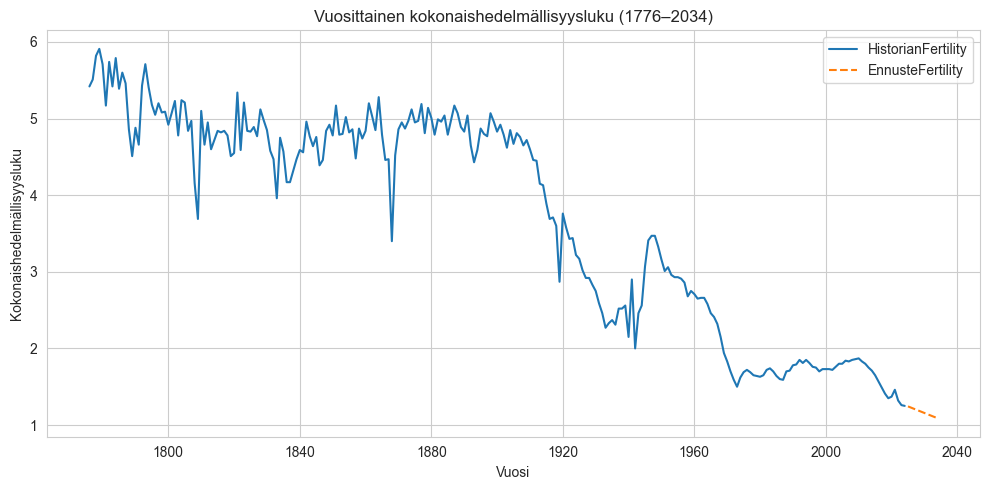

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(df_full.index, df_full["HistorianFertility"], label="HistorianFertility")
plt.plot(df_full.index, df_full["EnnusteFertility"], label="EnnusteFertility", linestyle="--")
plt.title("Vuosittainen kokonaishedelmällisyysluku (1776–2034)")
plt.xlabel("Vuosi")
plt.ylabel("Kokonaishedelmällisyysluku")
plt.legend()
plt.tight_layout()
plt.savefig("fertility_annual_forecast_2034.png")
plt.show()

# Yhteenveto

Jupyter-notebookissa:
- **Tehtävä 1**:   
  - Ladataan lentomatkustajadatan Excel, muutetaan `Kuukausi` datetime-indeksiksi ja sovitetaan Holt-Winters (trend="add", seasonal="add", period=12).  
  - Ennustetaan vuoden 2024 kuukausittaiset matkustajamäärät, verrataan vuoden 2024 todellisiin arvoihin ja esitetään ero DataFrame-muodossa.  
  - Piirretään hajontakaavio todellisen ja ennustetun vertailusta ja tallennetaan kuva `fertility_2024_scatter.png`.
- **Tehtävä 2**:  
  - Haetaan vuosittainen kokonaishedelmällisyysluku (tfr) JSON-stat2-rajapinnasta (vuodet 1776–2024).  
  - Muutetaan `Year` datetime-indeksiksi ja sovitetaan Holt-Winters ilman kausikomponenttia (trend="add").  
  - Ennustetaan vuodet 2025–2034 ja yhdistetään ennuste historiallisiin arvoihin.  
  - Piirretään viivakaavio historiallisen datan ja ennusteen yhdistelmästä, tallennetaan kuva `fertility_annual_forecast_2034.png`.